In [1]:
# Modules...
import numpy as np              # numeric
import matplotlib.pyplot as plt # plotting

# inline plots
%matplotlib inline 

# filter and hilbert functions
from scipy.signal import butter,filtfilt,hilbert

# coherence and smoothing functions
from scipy.signal import coherence,savgol_filter

# Bessel function
from scipy.special import iv

# Von Mises function
from scipy.stats import vonmises

# loading Matlab data
from scipy.io import loadmat

PLV spectrum:

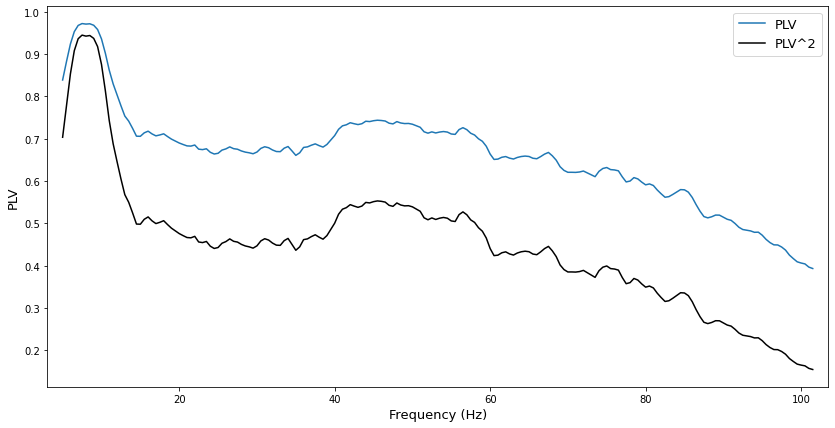

In [5]:
LFP     = loadmat('LFP_HG_HFO.mat')
LFP1 = LFP['lfpHFO'][0]
LFP2  = LFP['lfpHG'][0]
srate   = 1000
dt = 1./srate
t = np.arange(0,len(LFP1))*dt

freqvector = np.arange(3.,100.,0.5)
bandwidth = 4. # in Hz
order = 2 # filter order
nyq = 0.5*srate # Nyquist frequency

PLVspectrum = np.empty(len(freqvector))

for i,f in enumerate(freqvector):
    # Filtering the signal
    lowcut = f/nyq
    highcut = (f+bandwidth)/nyq
    b,a = butter(order,[lowcut,highcut],'bandpass')
    LFPfilt1 = filtfilt(b,a,LFP1)
    LFPfilt2 = filtfilt(b,a,LFP2)
    
    Phase1 = np.angle(hilbert(LFPfilt1))
    Phase2 = np.angle(hilbert(LFPfilt2))
    
    DeltaPhase = np.angle(np.exp(1j*(Phase2-Phase1)))
    PLV = abs(np.mean(np.exp(1j*DeltaPhase)))
    
    PLVspectrum[i] = PLV

plt.figure(figsize=(14,7))

plt.plot(freqvector+bandwidth/2.,PLVspectrum,label='PLV')
plt.plot(freqvector+bandwidth/2.,PLVspectrum**2,'k',label='PLV^2')
plt.xlabel('Frequency (Hz)',size=13)
plt.ylabel('PLV',size=13)
plt.legend(fontsize=13)
plt.xlim(freqvector[0],freqvector[-1]+bandwidth);

Defining an entropy based modulation index:

Entropy          = 2.3239746556311984
Modulation Index = 0.21072412365322407


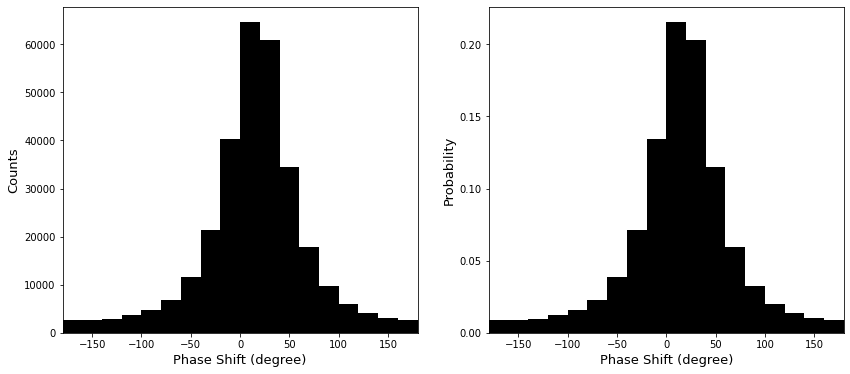

In [6]:
# Filtering the signal
order = 3 # filter order
nyq = 0.5*srate # Nyquist frequency
low_freq = 30. # low-pass frequency
lowcut = low_freq/nyq # low cutoff
# Butterworth transfer function
high_freq = 100. # high-pass frequency
highcut = high_freq/nyq # high cutoff
b,a = butter(order,[lowcut,highcut],'bandpass')
# filtered signal
LFPfilt1 = filtfilt(b,a,LFP1)
LFPfilt2 = filtfilt(b,a,LFP2)

Phase1 = np.angle(hilbert(LFPfilt1))
Phase2 = np.angle(hilbert(LFPfilt2))
DeltaPhase = np.angle(np.exp(1j*(Phase1-Phase2)))

phasebincenters = np.arange(-180,181,20)
counts,phasebins = np.histogram(DeltaPhase,np.deg2rad(phasebincenters))

plt.figure(figsize=(14,6))
plt.subplot(121)
plt.bar(np.rad2deg(phasebins[:-1])+10,counts,20,color='k')
plt.xlabel('Phase Shift (degree)',size=13)
plt.ylabel('Counts',size=13)
plt.xlim(-180,180)

# converting histogram counts into probabilities
counts.dtype=float
p = counts/np.sum(counts) # probability density
plt.subplot(122)
plt.bar(np.rad2deg(phasebins[:-1])+10,p,20,color='k')
plt.xlabel('Phase Shift (degree)',size=13)
plt.ylabel('Probability',size=13)
plt.xlim(-180,180)

# Entropy as a measure of imprevisibility --> H = -sum(p*log(p))
H = -np.sum(p[p>0]*np.log(p[p>0])) # to prevent 0*-Inf
# maximum entropy
Hmax = np.log(len(phasebins))
# Modulation Index "inversely proportional" to entropy
MI = (Hmax-H)/Hmax

print('Entropy          = '+str(H))
print('Modulation Index = '+str(MI))

Von Mises Distribution:

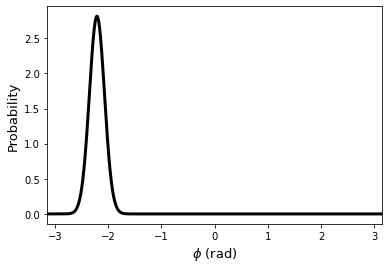

In [7]:
meanphi = np.pi+0.1*135
kappa = 50.

phi = np.arange(-np.pi,np.pi,0.01)
VonMises = np.exp(kappa*(np.cos(phi-meanphi)))/(2*np.pi*iv(0,kappa))

plt.plot(phi,VonMises,'k',linewidth=3)
plt.xlim(-np.pi,np.pi)
plt.xlabel('$\phi$ (rad)',size=13)
plt.ylabel('Probability',size=13);

Fitting the probability density function of the phase differences with a Von Mises function:

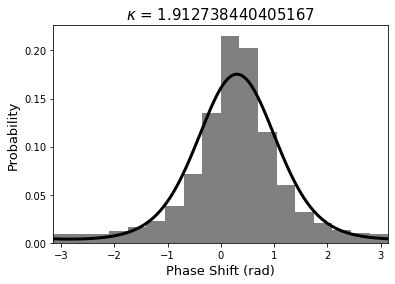

In [8]:
kappa, meanphi, fScale = vonmises.fit(DeltaPhase, fscale=1)

VonMises = np.exp(kappa*(np.cos(phi-meanphi)))/(2*np.pi*iv(0,kappa))

dPhi = phasebins[2]-phasebins[1]
plt.bar(phasebins[:-1]+np.deg2rad(10),p,np.deg2rad(20),color='grey')
plt.xlabel('Phase Shift (rad)',size=13)
plt.ylabel('Probability',size=13)
plt.xlim(-np.pi,np.pi)
plt.plot(phi,VonMises*dPhi,'k',linewidth=3)
plt.title('$\kappa$ = '+str(kappa),size=15);

Metrics based on "height ratio":

In [9]:
print('HR1 = '+str(max(p)/min(p)))
print('HR2 = '+str((max(p)-min(p))/max(p)))
print('HR3 = '+str((max(p)-min(p))/(max(p)+min(p))))

HR1 = 24.878274268104775
HR2 = 0.9598042858912423
HR3 = 0.92271509377791


Comparing different synchrony metrics:

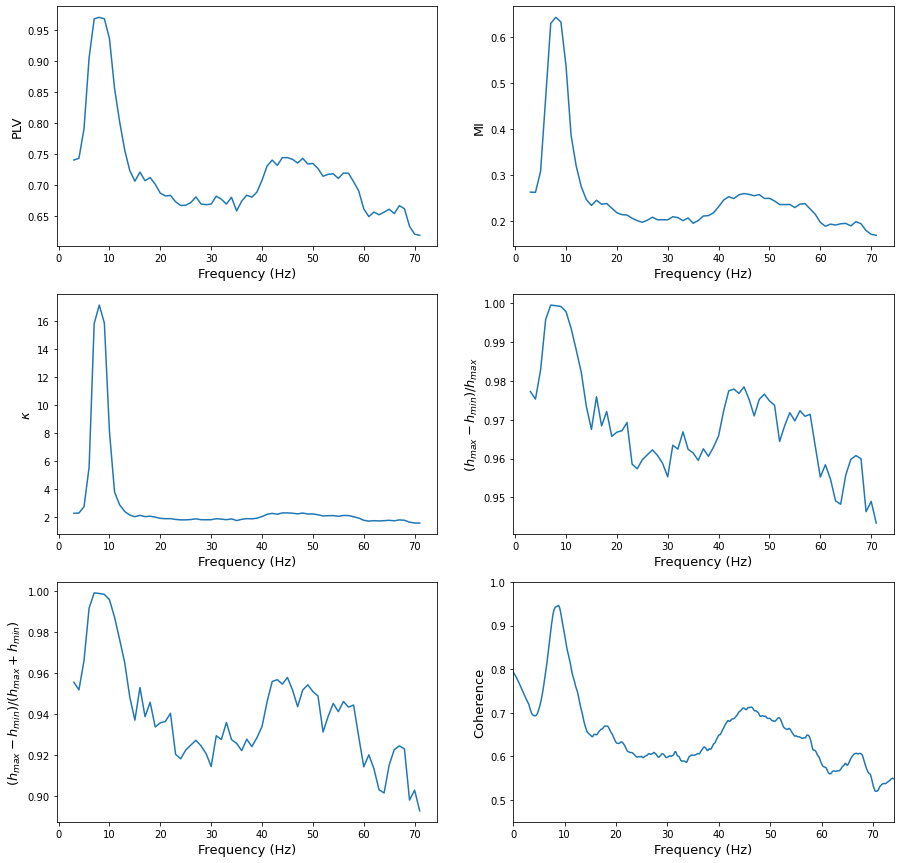

In [10]:
freqvector = np.arange(1.,70.)
bandwidth = 4.
order = 3       # filter order
nyq = 0.5*srate # Nyquist frequency (Hz)

PLVspectrum   = np.empty(len(freqvector))
MIspectrum    = np.empty(len(freqvector))
Kappaspectrum = np.empty(len(freqvector))
HR2spectrum   = np.empty(len(freqvector))
HR3spectrum   = np.empty(len(freqvector))

for i,f in enumerate(freqvector):
    # Filtering the signal
    lowcut = f/nyq
    highcut = (f+bandwidth)/nyq
    b,a = butter(order,[lowcut,highcut],'bandpass')
    LFPfilt1 = filtfilt(b,a,LFP1)
    LFPfilt2 = filtfilt(b,a,LFP2)
    
    Phase1 = np.angle(hilbert(LFPfilt1))
    Phase2 = np.angle(hilbert(LFPfilt2))
    DeltaPhase = np.angle(np.exp(1j*(Phase2-Phase1)))
    
    PLV = abs(np.mean(np.exp(1j*DeltaPhase)))
    PLVspectrum[i] = PLV

    phasebincenters = np.arange(-180,181,20)
    counts,phasebins = np.histogram(DeltaPhase,np.deg2rad(phasebincenters))
    counts.dtype=float
    p = counts/np.sum(counts) # probability density
    H = -np.sum(p[p>0]*np.log(p[p>0]))
    Hmax = np.log(len(phasebins))
    MI = (Hmax-H)/Hmax
    MIspectrum[i] = MI
    

    kappa,meanphi,fScale = vonmises.fit(DeltaPhase,fscale=1)
    Kappaspectrum[i] = kappa

    HR2 = (max(p)-min(p))/max(p)
    HR2spectrum[i] = HR2
    
    HR3 = (max(p)-min(p))/(max(p)+min(p))
    HR3spectrum[i] = HR3

plt.figure(figsize=(15,15))
plt.subplot(321)
plt.plot(freqvector+bandwidth/2,PLVspectrum)
plt.xlabel('Frequency (Hz)',size=13)
plt.ylabel('PLV',size=13)

plt.subplot(322)
plt.plot(freqvector+bandwidth/2,MIspectrum)
plt.xlabel('Frequency (Hz)',size=13)
plt.ylabel('MI',size=13)

plt.subplot(323)
plt.plot(freqvector+bandwidth/2,Kappaspectrum)
plt.xlabel('Frequency (Hz)',size=13)
plt.ylabel('$\kappa$',size=13)

plt.subplot(324)
plt.plot(freqvector+bandwidth/2,HR2spectrum)
plt.xlabel('Frequency (Hz)',size=13)
plt.ylabel('$(h_{max}-h_{min})/h_{max}$',size=13);

plt.subplot(325)
plt.plot(freqvector+bandwidth/2,HR3spectrum)
plt.xlabel('Frequency (Hz)',size=13)
plt.ylabel('$(h_{max}-h_{min})/(h_{max}+h_{min})$',size=13);

# comapring with Fourier-based phase coherence
plt.subplot(326)
F, Cxy = coherence(LFP1,LFP2,srate,nperseg=4*srate,nfft=2**13)
# smoothing coherence signal
Cxy_smoothed = savgol_filter(Cxy, 51, 3) # window size 51, polynomial order 3
plt.plot(F,Cxy_smoothed)
plt.xlim(0,74)
plt.ylim(0.45,1)
plt.xlabel('Frequency (Hz)',size=13)
plt.ylabel('Coherence',size=13);

Inter-trial coherence (ITC)

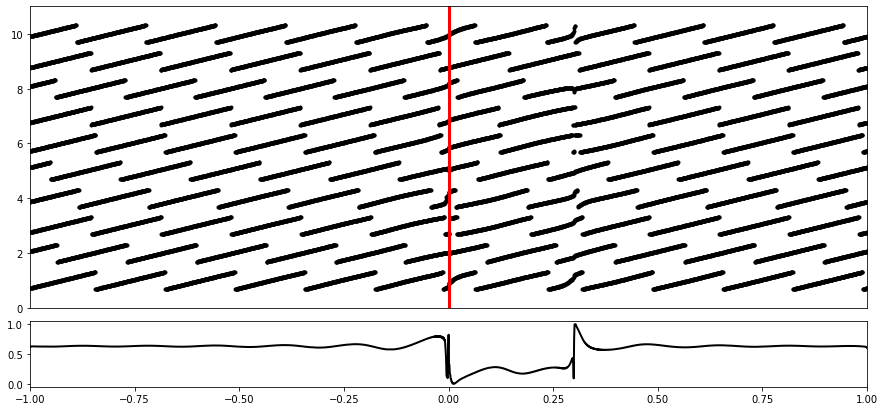

In [11]:
srate = 1000
dt = 1./srate
t = np.arange(0.,2+dt/2.,dt)


ERP = np.zeros(len(t))
PhaseAll = np.empty((10,len(t)))

plt.figure(figsize=(15,7))
plt.subplot2grid((5,1),(0,0),rowspan=4)
for ntrial in range(10):
    LFP = 0.25*np.sin(2*np.pi*6*t+np.random.rand()*2*np.pi)
    LFP[1000:1300] = 0.25*np.sin(2*np.pi*6*t[1000:1300]+np.random.rand()*2*np.pi)
    
    Phase = np.angle(hilbert(LFP))
    PhaseAll[ntrial] = Phase
    
    plt.plot(t-1,0.1*Phase+ntrial+1,'k.')
    
    ERP = ERP + LFP

plt.plot([0,0],[0,ntrial+2],'r',linewidth=3)
plt.xlim(-1,1)
plt.ylim(0,ntrial+2)
plt.xticks([],[])

ERP = ERP/ntrial
ITC = abs(np.mean(np.exp(1j*PhaseAll),axis=0))
# normalization (range from 0 to 1)
NormalizedITC = (ITC - min(ITC))/(max(ITC)-min(ITC))

plt.subplot(5,1,5)
plt.plot(t-1,NormalizedITC,'k',linewidth=2)
plt.xlim(-1,1);

ITC or GPC spectrum<br>
(Inter-Trial Coherence)<br>
(Global Phase Coherence)

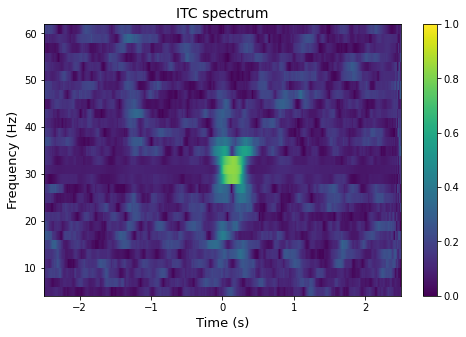

In [12]:
srate = 1000
dt = 1./srate
t = np.arange(0.,5+dt/2.,dt)
freqvector = np.arange(2.,60.1,2.)
order = 3 # filter order
nyq = 0.5*srate # Nyquist frequency

PhaseAll = np.empty((60,len(t),len(freqvector)))

for ntrial in range(60):
    LFP = 0.5*np.sin(2*np.pi*30*t+np.random.rand()*2*np.pi)
    LFP[2500:2800] = 0.5*np.sin(2*np.pi*30*t[2500:2800]+0.5*np.random.randn())
    LFP = LFP + np.random.randn(len(LFP))

    for count,f in enumerate(freqvector):
        # Filtering the signal
        lowcut = f/nyq
        highcut = (f+4)/nyq
        b,a = butter(order,[lowcut,highcut],'bandpass')
        # filtered signal
        LFPfiltered = filtfilt(b,a,LFP)
        Phase = np.angle(hilbert(LFPfiltered))
        PhaseAll[ntrial,:,count] = Phase


plt.figure(figsize=(8,5))
ITCspectrum = abs(np.mean(np.exp(1j*PhaseAll),axis=0))
plt.pcolormesh(t-2.5,freqvector+2,ITCspectrum.T,vmin=0.,vmax=1)
plt.xlabel('Time (s)',size=13)
plt.ylabel('Frequency (Hz)',size=13)
plt.title('ITC spectrum',size=14)
plt.colorbar();